# LSTM forecasting of renewable energy grid production
## - Take mean of every 10 timesteps
## - 32,500 timesteps = 325,000 minutes = ~225.7 days: 60% training, 20% validation, 20% test
## - Lookback = 12 timesteps = 2hr
## - lr = 0.001, hidden_size = 35, num_epochs = 50, batch_size = 512

## Model Architecture
### 1 Linear input layer
### 1 LSTM
### 2 Linear layers, 2nd to output

In [1]:
from data_handler import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from torch.utils.data import TensorDataset, DataLoader

### Set seed

In [2]:
import random

def set_random_seed(seed_value=42):
    # Python random seed
    random.seed(seed_value)
    
    # Numpy random seed
    np.random.seed(seed_value)
    
    # PyTorch seed
    torch.manual_seed(seed_value)
    
    # If using CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
        torch.backends.cudnn.deterministic = True  # For reproducibility
        torch.backends.cudnn.benchmark = False  # Disable auto-optimization for determinism

set_random_seed()

### Define Standard LSTM model

In [3]:
class StandardLSTMModel(nn.Module):
    def __init__(self, in_features, hidden_size, out_features, num_layers, bias=True):
        super(StandardLSTMModel, self).__init__()

        # First Linear Layer
        self.fc1 = nn.Linear(in_features, hidden_size, bias=bias)
        
        # LSTM Layers (num_layers stacked LSTMs)
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bias=bias)

        # Dropout layer to avoid overfitting
        self.dropout = nn.Dropout(p=0.5)

        # Second Linear Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=bias)

        # Final Output Layer
        self.fc3 = nn.Linear(hidden_size, out_features, bias=bias)

    def forward(self, x, hidden_states=None):
        # Pass input through the first linear layer
        x = self.fc1(x)
        x = F.relu(x)  # Apply ReLU activation

        # Initialize hidden states if not provided
        if hidden_states is None:
            hidden_states = (
                torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device),
                torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)
            )
        
        # Pass through LSTM layers, returning the output sequence and final states
        hidden_seq, (hidden_last, cell_last) = self.lstm(x, hidden_states)

        # Apply dropout to the last hidden state
        # hidden_last = self.dropout(hidden_last[-1])  # Take the last layer’s hidden state
        hidden_last = hidden_seq[:, -1, :]  # Last time step output

        # Pass through second linear layer
        hidden_last = self.fc2(hidden_last)
        hidden_last = F.relu(hidden_last)  # Apply ReLU activation

        # Pass through the final output layer
        output = self.fc3(hidden_last)
        
        return output

### Typical loading, scaling, and preparation of data

In [4]:
#-----------------------------------------------LOAD DATA---------------------------------------------------------#
df = pd.read_csv('../dataset/PSML.csv')
print(df.shape)

# Convert the 'time' column to datetime and set it as the index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

df_mean10 = df.resample('10min').mean()

# Reset the index and drop the old index column
df_mean10 = df_mean10.reset_index(drop=True)

columns = df_mean10.columns
print(columns)
print(df_mean10.shape)

data = df_mean10.iloc[:32500]
print(data.shape)
data.head()

(1573923, 12)
Index(['load_power', 'wind_power', 'solar_power', 'DHI', 'DNI', 'GHI',
       'Dew Point', 'Solar Zenith Angle', 'Wind Speed', 'Relative Humidity',
       'Temperature'],
      dtype='object')
(157681, 11)
(32500, 11)


,load_power,wind_power,solar_power,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,Relative Humidity,Temperature
0,0.782822,0.004630,0.0,0.0,0.0,0.0,-7.70,168.689,1.2,23.780,12.50
1,0.777255,0.004792,0.0,0.0,0.0,0.0,-7.70,168.040,1.2,23.780,12.50
2,0.771689,0.004595,0.0,0.0,0.0,0.0,-7.70,167.043,1.2,23.892,12.43
3,0.766122,0.005097,0.0,0.0,0.0,0.0,-8.19,165.784,1.2,22.995,12.40
4,0.760556,0.004799,0.0,0.0,0.0,0.0,-8.40,164.318,1.2,22.590,12.40


In [5]:
#---------------------------------SPLIT, SCALE, AND CONVERT TO NP ARRAYS---------------------------------------#

# Use the function with a list of target columns
X, y = feature_label_split(data, targets=['solar_power', 'wind_power'], drop_cols=['load_power'])

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.20)

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_arr = scaler_X.fit_transform(X_train)
X_val_arr = scaler_X.transform(X_val)       # All as numpy.nd arrays
X_test_arr = scaler_X.transform(X_test)

y_train_arr = scaler_y.fit_transform(y_train)
y_val_arr = scaler_y.transform(y_val)
y_test_arr = scaler_y.transform(y_test)

#---------------------------------DEFINE LOOKBACK AND FORMAT DATA------------------------------------------#

# Define the sequence length
seq_length = 12

# Convert training, validation, and test sets into sequences
train_features_seq, train_targets_seq = create_sequences(torch.Tensor(X_train_arr), torch.Tensor(y_train_arr), seq_length)
val_features_seq, val_targets_seq = create_sequences(torch.Tensor(X_val_arr), torch.Tensor(y_val_arr), seq_length)
test_features_seq, test_targets_seq = create_sequences(torch.Tensor(X_test_arr), torch.Tensor(y_test_arr), seq_length)

# Check the new shapes of the data
print(f"Train features shape: {train_features_seq.shape}")
print(f"Train targets shape: {train_targets_seq.shape}")
print(f"Test features shape: {test_features_seq.shape}")
print(f"Test targets shape: {test_targets_seq.shape}")

#--------------------------STORE AS TENSORDATASET AND CREATE DATALOADERS-----------------------------#

# Create TensorDatasets
train = TensorDataset(train_features_seq, train_targets_seq)
val = TensorDataset(val_features_seq, val_targets_seq)
test = TensorDataset(test_features_seq, test_targets_seq)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# Investigating the shape of data in train_loader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"  Input shape: {inputs.shape}")
    print(f"  Target shape: {targets.shape}")
    
    # Break after inspecting the first batch
    break

Train features shape: torch.Size([19488, 12, 8])
Train targets shape: torch.Size([19488, 2])
Test features shape: torch.Size([6488, 12, 8])
Test targets shape: torch.Size([6488, 2])
Batch 1:
  Input shape: torch.Size([512, 12, 8])
  Target shape: torch.Size([512, 2])


### Instantiate and train LSTM model

In [6]:
# Training function with validation
def train_lstm(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()  # Set model to training mode
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()  # Ensure model is in training mode

        for inputs, targets in train_loader:  # Training loop
            # Move data to the appropriate device (CPU or GPU)
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate loss for this batch
            epoch_loss += loss.item()
        
        # Average training loss for the epoch
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation step
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation for validation
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_targets).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses

In [7]:
# Hyperparameters from GridSearch
input_size = 8  # Number of input features
output_size = 2  # Number of outputs
hidden_size = 35  # Number of hidden units
num_layers = 1  # Number of stacked LSTM layers
num_epochs = 50  # Number of epochs for training
lr = 0.001

# Initialize the LSTM model
model = StandardLSTMModel(
    input_size, 
    hidden_size,
    output_size,
    num_layers
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # regression task
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Timing
start = time.time()

# Train the model and visualize losses
train_losses, val_losses = train_lstm(model, train_loader, val_loader, criterion, optimizer, num_epochs)

end = time.time()
train_time = end - start
print(f"Training time: {train_time:.4f} seconds")

Epoch [1/50], Train Loss: 0.0741, Val Loss: 0.0463
Epoch [2/50], Train Loss: 0.0258, Val Loss: 0.0128
Epoch [3/50], Train Loss: 0.0132, Val Loss: 0.0081
Epoch [4/50], Train Loss: 0.0095, Val Loss: 0.0046
Epoch [5/50], Train Loss: 0.0061, Val Loss: 0.0034
Epoch [6/50], Train Loss: 0.0046, Val Loss: 0.0032
Epoch [7/50], Train Loss: 0.0036, Val Loss: 0.0024
Epoch [8/50], Train Loss: 0.0031, Val Loss: 0.0019
Epoch [9/50], Train Loss: 0.0028, Val Loss: 0.0017
Epoch [10/50], Train Loss: 0.0028, Val Loss: 0.0016
Epoch [11/50], Train Loss: 0.0028, Val Loss: 0.0015
Epoch [12/50], Train Loss: 0.0030, Val Loss: 0.0014
Epoch [13/50], Train Loss: 0.0029, Val Loss: 0.0014
Epoch [14/50], Train Loss: 0.0027, Val Loss: 0.0013
Epoch [15/50], Train Loss: 0.0024, Val Loss: 0.0013
Epoch [16/50], Train Loss: 0.0023, Val Loss: 0.0013
Epoch [17/50], Train Loss: 0.0022, Val Loss: 0.0013
Epoch [18/50], Train Loss: 0.0021, Val Loss: 0.0013
Epoch [19/50], Train Loss: 0.0021, Val Loss: 0.0012
Epoch [20/50], Train 

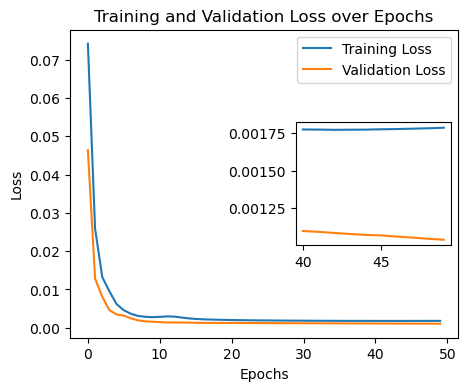

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create the main plot
plt.figure(figsize=(5, 4))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend(loc='upper right')

last_epochs = 10

# Add a small inset zoomed view of the last 10 epochs
ax = plt.gca()  # Get the current axes
inset_ax = inset_axes(ax, width="40%", height="40%", loc="center right")  # Adjust as needed

# Plot the zoomed-in section on the inset
inset_ax.plot(range(len(train_losses) - last_epochs, len(train_losses)), train_losses[-last_epochs:], label="Training Loss")
inset_ax.plot(range(len(val_losses) - last_epochs, len(val_losses)), val_losses[-last_epochs:], label="Validation Loss")

# Save the figure (use any desired file path and format)
# plt.savefig("LSTM_train_val_loss.png", dpi=300, bbox_inches='tight')

plt.show()

# Predict on test data (6470 'future' time steps)

In [8]:
def predict_standard_lstm(model, test_loader, scaler_y=None, device=torch.device('cpu')):
    model.eval()  # Set the model to evaluation mode
    
    all_predictions = []
    true_values = []

    # Disable gradient computation for inference
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Store true values for comparison
            true_values.append(targets.cpu().numpy())

            # Generate predictions for each input
            outputs = model(inputs)

            # Store predictions
            all_predictions.append(outputs.cpu().numpy())

    # Concatenate predictions and true values across all batches
    all_predictions = np.concatenate(all_predictions, axis=0)  # Shape: (total_samples, num_outputs)
    true_values = np.concatenate(true_values, axis=0)  # Shape: (total_samples, num_outputs)

    # Apply inverse scaling if scaler_y is provided
    if scaler_y is not None:
        true_values = scaler_y.inverse_transform(true_values)
        all_predictions = scaler_y.inverse_transform(all_predictions)

    return all_predictions, true_values

In [9]:
# Assuming you have a test DataLoader
test_predictions, test_actuals = predict_standard_lstm(model, test_loader, scaler_y=scaler_y, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

print("Test Predictions:", test_predictions)
print("Test Actuals:", test_actuals)
test_actuals.shape

Test Predictions: [[ 5.1921457e-01  7.4430883e-02]
 [ 4.9848190e-01  7.2117031e-02]
 [ 4.7692183e-01  6.9194287e-02]
 ...
 [ 1.7925195e-01 -3.1945505e-03]
 [ 2.1158579e-01 -1.1871179e-03]
 [ 2.4487025e-01  2.6666812e-04]]
Test Actuals: [[0.48278576 0.07997046]
 [0.45701998 0.08355577]
 [0.430439   0.0777962 ]
 ...
 [0.1843885  0.0070052 ]
 [0.21476443 0.00798081]
 [0.24600767 0.00790257]]


(6144, 2)

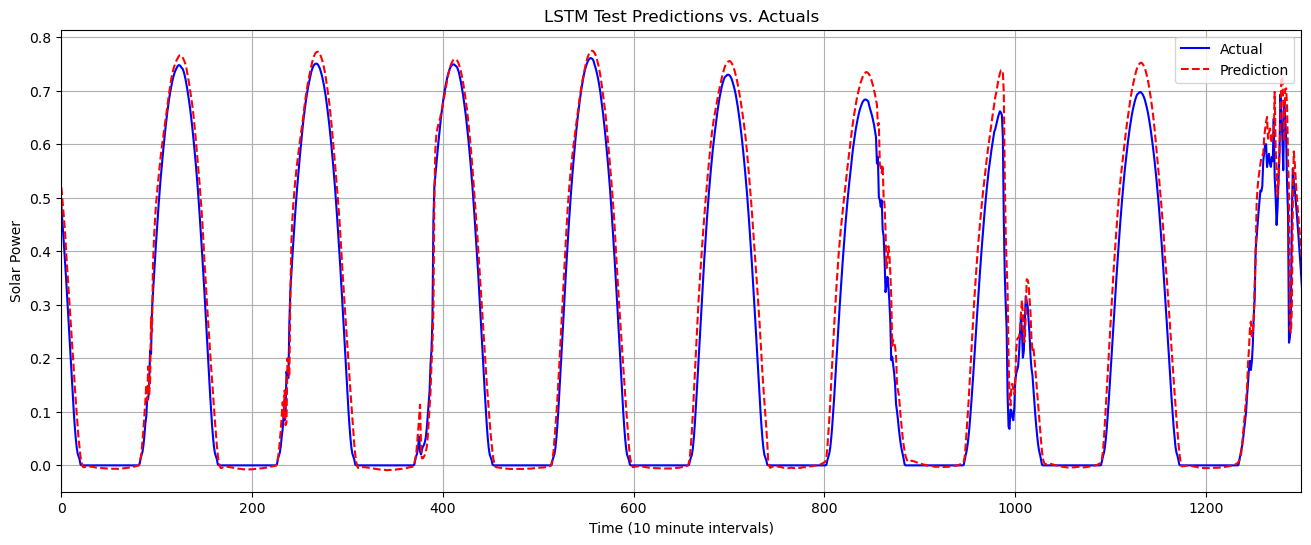

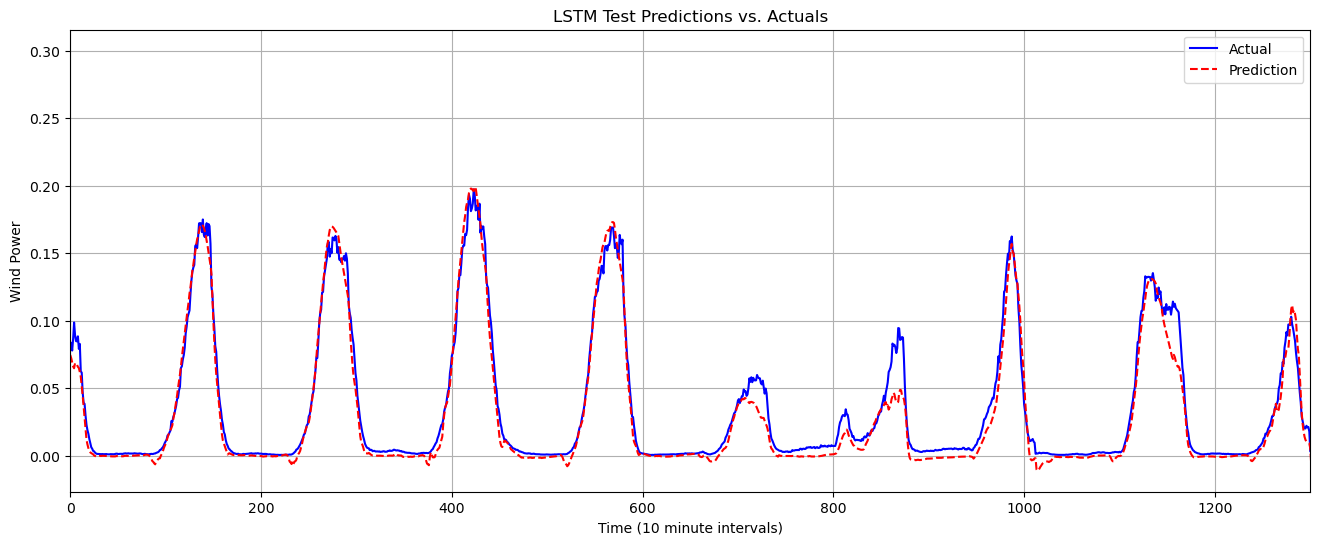

In [10]:
labels = ['Solar Power', 'Wind Power']

# Plot predictions vs actuals
for output_index, label in zip(range(0,2), labels):
    plt.figure(figsize=(16,6))
    plt.xlim(0, 1300)
    plt.plot(test_actuals[:, output_index], label='Actual', linestyle='-', color='blue')
    plt.plot(test_predictions[:, output_index], label='Prediction', color='r', linestyle='--')
    plt.xlabel('Time (10 minute intervals)')
    plt.ylabel(label)
    plt.title('LSTM Test Predictions vs. Actuals')
    plt.legend()
    plt.grid(True)

plt.show()

# Calculate R2, MAE, RMSE

In [11]:
# Number of outputs
n_outputs = test_actuals.shape[1]

# Calculate MAPE and RMSPE for each output
r2_scores = [r2_score(test_actuals[:, i], test_predictions[:, i]) for i in range(n_outputs)]

mae_scores = [mean_absolute_error(test_actuals[:, i], test_predictions[:, i]) for i in range(n_outputs)]
rmse_scores = [np.sqrt(mean_squared_error(test_actuals[:, i], test_predictions[:, i])) for i in range(n_outputs)]

print(f"R2: {r2_scores}")
print(f"MAE: {mae_scores}")
print(f"RMSE: {rmse_scores}")

R2: [0.9792647941981546, 0.9586383578580617]
MAE: [0.025159827, 0.007358506]
RMSE: [0.038435575, 0.011496801]


In [13]:
def save_arrays_to_csv(array1: np.ndarray, array2: np.ndarray, filename: str):
    # Create a DataFrame from the three arrays
    df = pd.DataFrame({
        'True Solar': array1[:, 0],
        'True Wind': array1[:, 1],
        'Predicted Solar': array2[:, 0],
        'Predicted Wind': array2[:, 1]
    })

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)


save_arrays_to_csv(test_actuals, test_predictions, 'StandardLSTMTest.csv')

# Predict on train

In [14]:
# Assuming you have a test DataLoader
train_predictions, train_actuals = predict_standard_lstm(model, train_loader, scaler_y=scaler_y, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

print("Test Predictions:", train_predictions)
print("Test Actuals:", train_actuals)

Test Predictions: [[-6.9907671e-03 -5.3625769e-04]
 [-7.1946462e-03 -1.5968083e-04]
 [-7.0607904e-03 -7.1569011e-05]
 ...
 [-5.3457986e-03 -1.0873989e-03]
 [-5.0047920e-03 -9.3996152e-04]
 [-4.6645491e-03 -7.6420151e-04]]
Test Actuals: [[0.         0.00601714]
 [0.         0.00606854]
 [0.         0.00640946]
 ...
 [0.         0.00082623]
 [0.         0.00074361]
 [0.         0.0007313 ]]


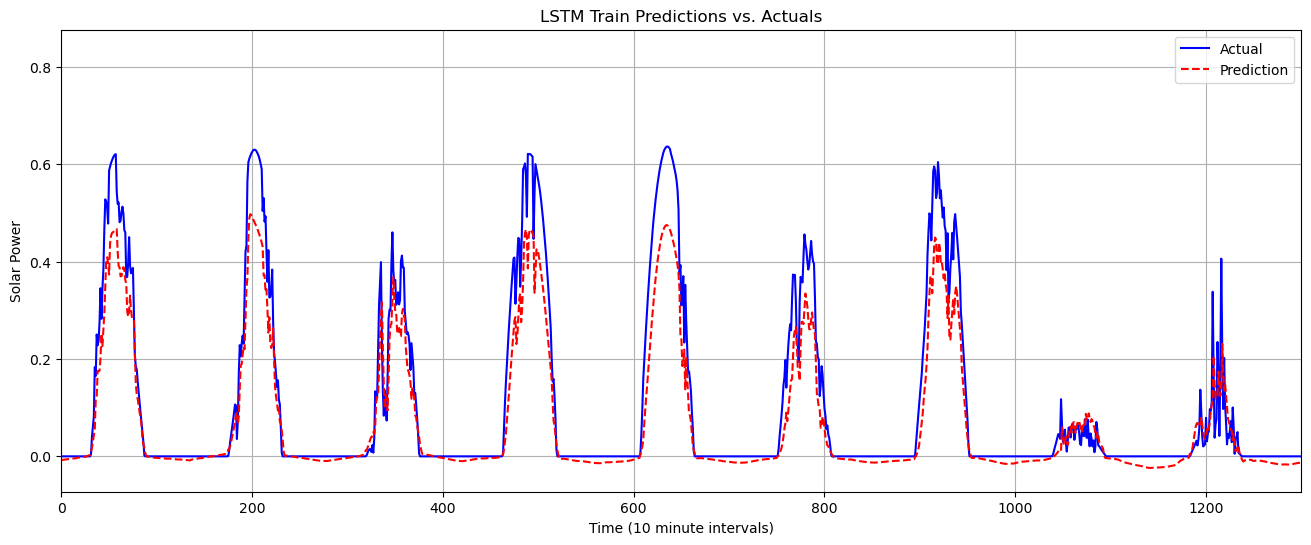

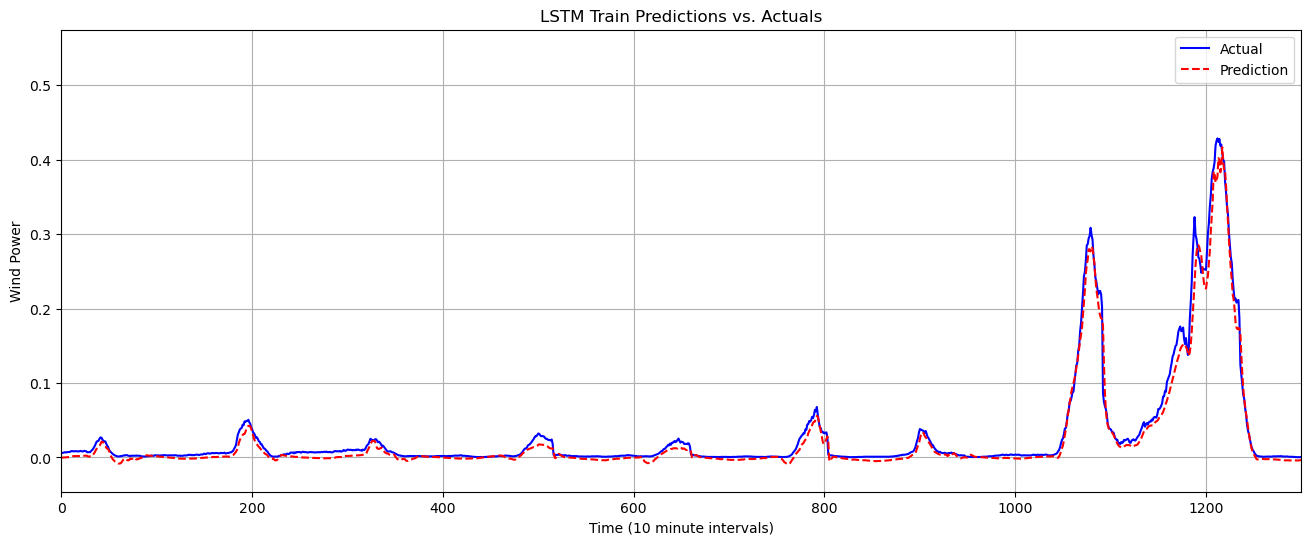

In [15]:
labels = ['Solar Power', 'Wind Power']

# Plot predictions vs actuals
for output_index, label in zip(range(0,2), labels):
    plt.figure(figsize=(16,6))
    plt.xlim(0, 1300)
    plt.plot(train_actuals[:, output_index], label='Actual', linestyle='-', color='blue')
    plt.plot(train_predictions[:, output_index], label='Prediction', color='r', linestyle='--')
    plt.xlabel('Time (10 minute intervals)')
    plt.ylabel(label)
    plt.title('LSTM Train Predictions vs. Actuals')
    plt.legend()
    plt.grid(True)

plt.show()

In [16]:
# Number of outputs
n_outputs = train_actuals.shape[1]

# Calculate MAPE and RMSPE for each output
r2_scores = [r2_score(train_actuals[:, i], train_predictions[:, i]) for i in range(n_outputs)]
mae_scores = [mean_absolute_error(train_actuals[:, i], train_predictions[:, i]) for i in range(n_outputs)]
rmse_scores = [np.sqrt(mean_squared_error(train_actuals[:, i], train_predictions[:, i])) for i in range(n_outputs)]

print(f"R2: {r2_scores}")
print(f"MAE: {mae_scores}")
print(f"RMSE: {rmse_scores}")

R2: [0.9302536448264143, 0.9853597011537408]
MAE: [0.042320624, 0.006245438]
RMSE: [0.06978856, 0.009552579]
